In [1]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

#### Load the data

In [2]:
data = np.load('data/citeseer.npz')
adj_indices = data['adj_indices']
adj_indptr = data['adj_indptr']
adj_data = data['adj_data']
adj_shape = data['adj_shape']
#print(adj_indices)
#print(adj_indptr)
#print(adj_shape)
conset = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape)
print(conset.shape)
#_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = conset + conset.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]


(4230, 4230)
Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Load the train, validation, test split from file

In [4]:
#loader = np.load('pretrained/cora_ml/split.npy').item()

In [5]:
#train_ones = loader['train_ones']
#val_ones = loader['val_ones']
#val_zeros = loader['val_zeros']
#test_ones = loader['test_ones']
#test_zeros = loader['test_zeros']
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [7]:
rw_len = 16
batch_size = 64

In [8]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### Create our NetGAN model

In [9]:
tf.reset_default_graph()
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=64, W_down_generator_size=64,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, learning_rate=0.0003)

W0714 14:10:33.145672 12248 deprecation_wrapper.py:119] From C:\workspace\netgan-master\netgan\netgan.py:108: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0714 14:10:33.188547 12248 deprecation_wrapper.py:119] From C:\workspace\netgan-master\netgan\netgan.py:116: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 14:10:33.196524 12248 deprecation_wrapper.py:119] From C:\workspace\netgan-master\netgan\netgan.py:119: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0714 14:10:34.637949 12248 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an i

#### Load pretrained model

In [10]:
saver = tf.train.Saver()
saver.restore(netgan.session, "snapshots/model_best_5.ckpt")

W0714 14:10:51.297544 12248 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


#### Generate random walks on the trained model

In [11]:
sample_many = netgan.generate_discrete(1000, reuse=True)

In [12]:
samples = []

In [13]:
for _ in range(6000):
    if (_+1) % 500 == 0:
        print(_+1)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


#### Assemble score matrix from the random walks

In [14]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Compute graph statistics

In [15]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))

In [16]:
A_select = train_graph

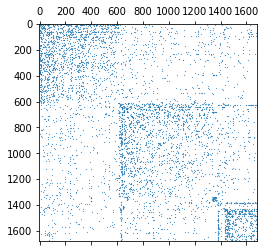

In [17]:
sampled_graph = utils.graph_from_scores(scores_matrix, A_select.sum())
plt.spy(sampled_graph, markersize=.2)
plt.show()

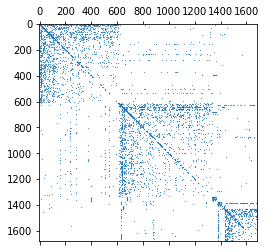

In [18]:
plt.spy(A_select, markersize=.2)
plt.show()

In [19]:
utils.edge_overlap(A_select.toarray(), sampled_graph)/A_select.sum()

0.1954582319545823

In [20]:
utils.compute_graph_statistics(sampled_graph)

C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'d_max': 56.0,
 'd_min': 1.0,
 'd': 2.9339678762641284,
 'LCC': 1681,
 'wedge_count': 13784.0,
 'claw_count': 77820.0,
 'triangle_count': 78,
 'square_count': 0,
 'power_law_exp': 2.2710970539987625,
 'gini': 0.41353749481949165,
 'rel_edge_distr_entropy': 0.9534784077195545,
 'assortativity': -0.1604396952595147,
 'clustering_coefficient': 0.0030069390902081727,
 'n_components': 1,
 'cpl': 6.508416192175859}

In [ ]:
utils.compute_graph_statistics(A_select.toarray())